### Installation

In [1]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.55.4
!pip install --no-deps trl==0.22.2

### Load Pretrained Model Qwen2.5 VL 7B using Unsloth

In [2]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.10.3: Fast Qwen2_5_Vl patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/6.90G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/791 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

In [3]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

<a name="Data"></a>
### Data Preparation


*   We will be loading our sample_products.csv created EDA Task 1 and download the images.



In [8]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2

from PIL import Image
import torch
from tqdm import tqdm

import humanize

DATA_DIR = "."

In [9]:
data_df = pd.read_csv(f"{DATA_DIR}/sample_products.csv", dtype={"code": str})
print(data_df.shape)
data_df.head()

(10000, 145)


,code,product_name,quantity,product_quantity,brands_en,countries_en,categories_en,serving_size,serving_quantity,nutriscore_score,...,beta-glucan_100g,inositol_100g,carnitine_100g,sulphate_100g,nitrate_100g,acidity_100g,carbohydrates-total_100g,is_image_en_lang,filled_count,filled_fraction
0,0062287212125,Honey Dijon Vinaigrette,350 mL,350.0,renee-s-gourmet,France,"Condiments,Sauces,Salad dressings,Vinaigrettes",15 mL,15.0000,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
1,6194005400300,Les classiques Chocolat aux céréales,NaN,NaN,"saida,said","France,Tunisia","Snacks,Sweet snacks,Cocoa and its products,Cho...",10 g,10.0000,27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
2,6194005412037,TRIS ( chocolat au lait ),30 g,30.0,"Said,Sotuchoc,Saida",Tunisia,"Snacks,Sweet snacks,Cocoa and its products,Cho...",NaN,NaN,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
3,6194005412075,Tris NOISETTES,30 g,30.0,"Said,Saida",Tunisia,"Snacks,Sweet snacks,Cocoa and its products,Cho...",10 g,10.0000,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
4,0043717277402,Kosher Dill Pickles,28 g,28.0,Zergut,United States,Undefined,28.3495g,28.3495,-5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN


## Define Helpful Utility Functions
* To download image by given URL.
* To get the image and save it to directory.
* To create the product image path given the product code.
* To read the image from storage disk.

In [27]:
import httpx
from io import BytesIO
from tenacity import retry, wait_fixed, stop_after_attempt

IMAGE_DIR = "./products_images"
os.makedirs(IMAGE_DIR, exist_ok=True)


def get_image_by_url(image_url: str, timeout_sec: int = 120) -> Image:
    with httpx.Client() as client:
        response = client.get(image_url, timeout=timeout_sec)
        return Image.open(BytesIO(response.content))

@retry(wait=wait_fixed(2), stop=stop_after_attempt(5))
def download_and_save(row: pd.Series):
    product_code = row['code']
    image_url = row['image_nutrition_url']

    if 'invalid' in image_url:
        image_url = image_url.replace('invalid', product_code)

    image_path = f"{IMAGE_DIR}/{product_code}.png"
    if not os.path.exists(image_path):
        try:
            image = get_image_by_url(image_url)
            image.save(image_path)
        except Exception as e:
            print("Failed to download image for url:", image_url)
            raise e


def get_product_image_path(product_code: str):
    return f"{IMAGE_DIR}/{product_code}.png"

def get_product_image(product_code: str) -> Image:
    try:
        return Image.open(get_product_image_path(product_code))
    except Exception as e:
        return Image.fromarray(np.zeros((512, 512, 3), dtype=np.uint8))

## Download Open Food Product Images using multi-processing.

In [16]:
from multiprocessing import Pool
from tqdm import tqdm

NUM_WORKERS = 12

with Pool(processes=NUM_WORKERS) as pool:
    list(
            tqdm(
                pool.imap(download_and_save, [row for _, row in data_df[['code', 'image_nutrition_url']].iterrows()]),
                total=len(data_df),
                dynamic_ncols=True,
            )
        )

100%|██████████| 10000/10000 [13:18<00:00, 12.52it/s]


## Define function to create target Labels

In [17]:
# Create target JSON
import json
from typing import Optional

ignore_attributes = ['nutrition-score-fr_100g']

def create_target_text_json(row, indent: Optional[int] = None):
    target_data = {}
    # Convert NaN values to None for JSON null
    for key, value in row.items():
        if key.endswith("_100g") and not pd.isna(value) and key not in ignore_attributes:
            target_data[key] = value

    return json.dumps(target_data, indent=indent)

## Target Label on example

In [18]:
print(create_target_text_json(data_df.loc[4], indent=4))

{
    "energy-kcal_100g": 50.4,
    "energy_100g": 212.0,
    "fat_100g": 0.0,
    "saturated-fat_100g": 0.0,
    "monounsaturated-fat_100g": 0.0,
    "polyunsaturated-fat_100g": 0.0,
    "omega-3-fat_100g": 0.0,
    "omega-6-fat_100g": 0.0,
    "trans-fat_100g": 0.0,
    "cholesterol_100g": 0.0,
    "carbohydrates_100g": 12.6,
    "sugars_100g": 0.0,
    "glucose_100g": 0.0,
    "fructose_100g": 0.0,
    "lactose_100g": 0.0,
    "fiber_100g": 12.7,
    "proteins_100g": 0.0,
    "salt_100g": 0.0063,
    "sodium_100g": 0.00252,
    "alcohol_100g": 0.0,
    "vitamin-a_100g": 0.0,
    "vitamin-d_100g": 0.0,
    "vitamin-e_100g": 0.0,
    "vitamin-k_100g": 0.0,
    "vitamin-c_100g": 0.0,
    "vitamin-b1_100g": 0.0,
    "vitamin-b2_100g": 0.0,
    "vitamin-pp_100g": 0.0,
    "vitamin-b6_100g": 0.0,
    "vitamin-b9_100g": 0.0,
    "vitamin-b12_100g": 0.0,
    "pantothenic-acid_100g": 0.0,
    "potassium_100g": 0.0,
    "calcium_100g": 0.0,
    "phosphorus_100g": 0.0,
    "iron_100g": 0.0,
  

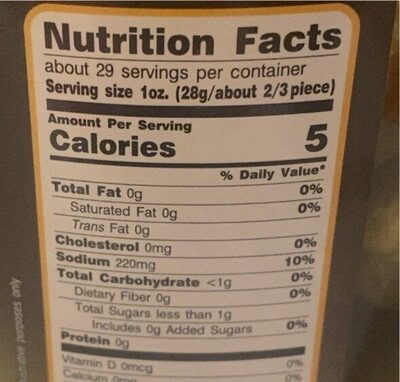

In [29]:
get_product_image(data_df.loc[4, 'code'])

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```

## Torch Dataset


*   Here, we define function to create conversation message.
*   Create Torch Dataset class for effective data loading while training.



In [73]:
instruction = """Extract Nutrition Facts data from the given image. Normalize the nutrient values to 100g.
                 Return the extraction output in JSON.
                """

def convert_to_conversation(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": get_product_image(sample['code'])}
            ],
        },
        {"role": "assistant", "content": [{"type": "text", "text": sample["text"]}]},
    ]
    return {"messages": conversation}


class OpenFoodProductsOcrDataset(torch.utils.data.Dataset):

    def __init__(self, data_df: pd.DataFrame):
        self.df = data_df.reset_index(drop=True)
        self.df = self.df.sample(frac=1) # shuffle

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.loc[index]
        target_text = create_target_text_json(row)

        sample = convert_to_conversation({'code': row['code'], 'text': target_text})

        return sample

### Create Train - Val Split

In [74]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(
    data_df,
    test_size=0.15,  # 15% for validation
    random_state=42, # for reproducibility
)

train_dataset = OpenFoodProductsOcrDataset(train_df)
val_dataset = OpenFoodProductsOcrDataset(val_df)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 8500
Validation dataset size: 1500


We look at how the conversations are structured for the first example:

In [76]:
train_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Extract Nutrition Facts data from the given image. Normalize the nutrient values to 100g.\n                 Return the extraction output in JSON.\n                '},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=239x400>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '{"energy-kcal_100g": 315.0, "energy_100g": 1320.0, "fat_100g": 2.78, "saturated-fat_100g": 0.0, "monounsaturated-fat_100g": 0.0, "polyunsaturated-fat_100g": 0.0, "carbohydrates_100g": 83.3, "sugars_100g": 18.5, "added-sugars_100g": 16.7, "fiber_100g": 18.5, "soluble-fiber_100g": 1.85, "insoluble-fiber_100g": 16.7, "proteins_100g": 7.41, "salt_100g": 0.926, "sodium_100g": 0.37, "vitamin-c_100g": 0.0115, "vitamin-b1_100g": 0.00115, "vitamin-b2_100g": 0.00164, "vitamin-b6_100g": 0.00192, "vitamin-b9_100g": 8.33e-05, "vitamin-b12_100g": 2.89e-06, "pantothenic-acid_100g": 0.000841, 

Let's first see before we do any finetuning what the model outputs for the first example!

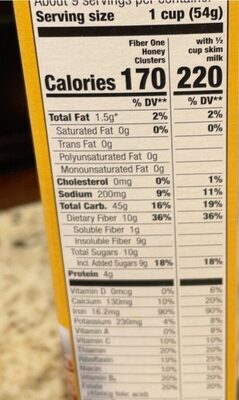

In [85]:
image = train_dataset[0]['messages'][0]['content'][1]['image']
image

## Sanity Test - Inference

In [86]:
FastVisionModel.for_inference(model) # Enable for inference!

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 512,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

```json
{
  "serving_size": "1 cup (54g)",
  "calories": {
    "Total": 170,
    "With milk": 220
  },
  "fat": {
    "Total Fat": "1.9g",
    "% DV": "2%",
    "Saturated": "0g",
    "% DV": "0%"
  },
  "trans_fat": "0g",
  "cholesterol": "0mg",
  "% DV": "0%",
  "sodium": "200mg",
  "% DV": "9%",
  "total_carb": {
    "Total": "45g",
    "% DV": "15%",
    "Dietary Fiber": "16g",
    "% DV": "36%"
  },
  "soluble_fiber": "9g",
  "net_tds": "10g",
  "protein": "4g"
}
```<|im_end|>



We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [111]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = train_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        #max_steps = 30,
        num_train_epochs = 5,
        learning_rate = 2e-4,
        logging_steps = 10,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [88]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
6.906 GB of memory reserved.


In [112]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 8,500 | Num Epochs = 5 | Total steps = 5,315
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 51,521,536 of 8,343,688,192 (0.62% trained)


Step,Training Loss
10,0.204600
20,0.175700
30,0.181300
40,0.189200
50,0.171400
60,0.159000
70,0.166700
80,0.155800
90,0.155000
100,0.156700


KeyboardInterrupt: 

## Test Inference On Sample Validation Image

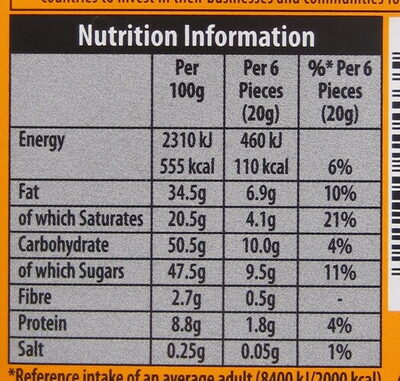

In [128]:
image = val_dataset[22]['messages'][0]['content'][1]['image']
image

In [129]:
FastVisionModel.for_inference(model) # Enable for inference!

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")


In [130]:
outputs = model.generate(**inputs, max_new_tokens = 1024, use_cache = True)

response = tokenizer.decode(outputs[0], skip_special_tokens=True)

In [131]:
response

'system\nYou are a helpful assistant.\nuser\nExtract Nutrition Facts data from the given image. Normalize the nutrient values to 100g.\n                 Return the extraction output in JSON.\n                \nassistant\n{"energy-kj_100g": 2310.0, "energy-kcal_100g": 555.0, "energy_100g": 2310.0, "fat_100g": 34.5, "saturated-fat_100g": 20.5, "carbohydrates_100g": 50.5, "sugars_100g": 47.5, "fiber_100g": 2.7, "proteins_100g": 8.8, "salt_100g": 0.25, "sodium_100g": 0.1, "fruits-vegetables-nuts-estimate-from-ingredients_100g": 0.0, "carbon-footprint-from-meat-or-fish_100g": 169.0}'

Prediction

In [132]:
result_json = eval(response.split("\n")[-1])
result_json

{'energy-kj_100g': 2310.0,
 'energy-kcal_100g': 555.0,
 'energy_100g': 2310.0,
 'fat_100g': 34.5,
 'saturated-fat_100g': 20.5,
 'carbohydrates_100g': 50.5,
 'sugars_100g': 47.5,
 'fiber_100g': 2.7,
 'proteins_100g': 8.8,
 'salt_100g': 0.25,
 'sodium_100g': 0.1,
 'fruits-vegetables-nuts-estimate-from-ingredients_100g': 0.0,
 'carbon-footprint-from-meat-or-fish_100g': 169.0}

Groundtruth

In [143]:
gt = eval(val_dataset[22]['messages'][1]['content'][0]['text'])
gt

{'energy-kcal_100g': 552.0,
 'energy_100g': 2310.0,
 'fat_100g': 35.0,
 'saturated-fat_100g': 21.0,
 'carbohydrates_100g': 50.0,
 'sugars_100g': 48.0,
 'fiber_100g': 2.5,
 'proteins_100g': 8.8,
 'salt_100g': 0.24,
 'sodium_100g': 0.096,
 'fruits-vegetables-nuts-estimate-from-ingredients_100g': 0.0,
 'cocoa_100g': 37.0}

### Save Finetuned Model Weights

In [110]:
#Save LoRA-only adapter (lightweight upload)

lora_repo_name = "open-food-products-qwen2vlm-lora-ocr"

model.save_pretrained(lora_repo_name, merge=False)
tokenizer.save_pretrained(lora_repo_name)

#OR Save full merged model

#If you want a single, standalone model (larger, but portable):

full_repo_name = "open-food-products-qwen2vlm-full-ocr"

model.save_pretrained(full_repo_name, merge=True)
tokenizer.save_pretrained(full_repo_name)

[]

### Login in and Upload Weights to HuggingFace

In [165]:
 !huggingface-cli login

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `kaggle` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.ca

In [ ]:
# upload to huggingface
from huggingface_hub import HfApi, create_repo

user_name = "sagar100rathod"
repo_id = f"{user_name}/{lora_repo_name}"

# Create it (set private=False if you want it public)
create_repo(repo_id, exist_ok=True, private=True)

api = HfApi()
api.upload_folder(
    folder_path=repo_name,
    repo_id=repo_id,
    repo_type="model",
)

## Key Performance Indicators (KPI's)


*   Since this is a structured text extraction (OCR + parsing + normalization problem, we want metrics that go beyond raw text accuracy

*   our goal is to measure how close the model’s output is to ground truth — both in content (which fields it finds) and values (how accurate those numbers are).







### 1. Field-Level Matching (Key Accuracy)

* Measures how well your OCR model identifies the correct nutrient fields.


* Precision = (Correctly predicted keys) / (Total predicted keys)

* Recall = (Correctly predicted keys) / (Total GT keys)

* F1-score = 2 × (Precision × Recall) / (Precision + Recall)

In [144]:
pred_keys = set(result_json.keys())
gt_keys = set(gt.keys())
tp = len(pred_keys & gt_keys)
precision = tp / len(pred_keys)
recall = tp / len(gt_keys)
f1 = 2 * precision * recall / (precision + recall)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.8461538461538461
Recall: 0.9166666666666666
F1-score: 0.8799999999999999


2. Value Accuracy (Numerical Similarity)
 * For matched keys, we care about how close the predicted values are.
 * Mean Absolute Percentage Error (MAPE) or Relative Error:

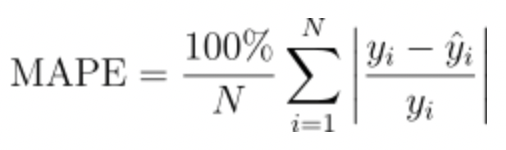

In [162]:
mae = np.mean([
    abs(result_json[k] - gt[k]) / (abs(gt[k]) + 1e-8)
    for k in pred_keys & gt_keys
])

mape = 100 * mae

print("Mean Absolute Error(MAE):", mae.item())
print("Mean Absolute Percentage Error(MAE):", mape.item())

Mean Absolute Error(MAE): 0.020661819480714314
Mean Absolute Percentage Error(MAE): 2.0661819480714314


3. Composite KPI (Overall Score)

* Combine structural and value accuracy into one weighted metric.

* Overall Score = F1(keys) × (1 − MAE)

* This gives a single interpretable number (e.g., 0.85 means “85% overall extraction quality”).

In [163]:
overall_score = f1 * (1 - mae)
print("Overall Score:", overall_score)

Overall Score: 0.8618175988569713
